In [89]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [90]:
def importData(file):

    # open json file
    with open(file) as f:
        data = json.load(f)

    keys = [i for i in data.keys()]

    d_vectors = {}

    for key in keys:

        d_vectors[key] = {}
        vectors = data[key]["vectors"]

        measurement = data[key]["attributes"]["measurement"]
        repetition = data[key]["attributes"]["repetition"]
        configs = data[key]["config"]
        mergedConfigs={}
        for config in configs:
            mergedConfigs.update(config)
        timeLimit = mergedConfigs["sim-time-limit"]

        d_vectors[key]["measurement"] = measurement
        d_vectors[key]["repetition"] = int(repetition)
        
        assert timeLimit.endswith('s'), "Time limit format is incorrect"
        timeLimit = timeLimit[:-1]  # Remove the 's' at the end
        d_vectors[key]["timeLimit"] = int(timeLimit)

        for a in vectors:

            module = a["module"]
            name = a["name"]

            if not module in d_vectors[key]:
                d_vectors[key][module] = {}
            d_vectors[key][module][name] = {}

            d_vectors[key][module][name]["times"] = a["time"]
            d_vectors[key][module][name]["values"] = a["value"]

    return d_vectors


d_vectors = importData("../multicore_sched/simulations/test.json")

In [91]:
firstIndex=list(d_vectors)[0]

In [92]:
firstIndex=list(d_vectors)[0]
print(d_vectors[firstIndex]['Computer.scheduler'].keys())

dict_keys(['turnaroundTime:vector', 'waitedReadyTime:vector', 'numProcReady:vector', 'numBusyCpus:vector', 'numBusyCpus:vector(timeavg)'])


In [93]:
iterationvars=['meanGenerationTime','meanProcessDuration']

In [94]:
measurements=[]
numRepetitions=0

for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']

    if not measurement in measurements:
        measurements.append(measurement)
    
    numRepetitions=max(numRepetitions,repetition+1)

In [95]:
import colorsys

def getColors(numColors, numVariations):
    colors = []
    for i in range(numColors):
        base_hue = i / numColors  # Base hue for this color group
        colors.append([])
        for j in range(numVariations):
            # Introduce hue variation (±2.5% maximum from base hue)
            hue_variation = 0.2  # Adjust this value to control hue variation strength
            hue = (base_hue + ((j/numVariations) - 0.5) * hue_variation) % 1
            
            # Original brightness progression with modified parameters
            lightness = 0.4 + j/numVariations/2.5  # 0.4 to 0.8 lightness range
            saturation = 0.8 - j/numVariations/4  # 0.7 to 0.45 saturation range
            
            colors[i].append(colorsys.hls_to_rgb(
                hue, 
                lightness, 
                saturation
            ))
    return colors

# Usage remains the same
numColors = len(measurements)
numVariations = numRepetitions
colors = getColors(numColors, numVariations)

In [96]:
def showColors():
    # Plot colors
    fig, ax = plt.subplots(figsize=(numVariations, numColors))
    for i, row in enumerate(colors):
        for j, color in enumerate(row):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color))

    ax.set_xlim(0, numVariations)
    ax.set_ylim(0, numColors)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    plt.show()
# showColors()

In [97]:
def measurementLabel(measurement, endline=True):
    for j, iterationvar in enumerate(iterationvars):
        measurement = measurement.replace(f"${j}", f"{iterationvar}")
    if endline:
        measurement = measurement.replace(', ', '\n')
    return measurement

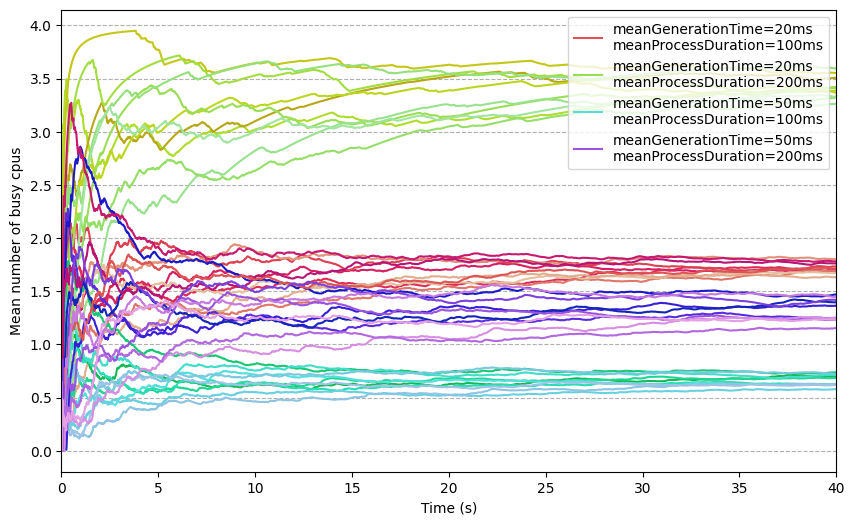

In [105]:
for key in d_vectors:

    measurement=d_vectors[key]['measurement']
    repetition=d_vectors[key]['repetition']
    timeLimit=d_vectors[key]['timeLimit']

    color=colors[measurements.index(measurement)][repetition]

    times = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["times"]
    values = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["values"]

    plt.plot(times, values,color=color)

# Plt labels
for i, measurement in enumerate(measurements):
    plt.plot([], [], color=colors[i][numVariations//2], label=f'{measurementLabel(measurement)}')

plt.xlim(0, 40)

plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus')
plt.legend(loc='upper right', framealpha=0.8)
plt.gcf().set_size_inches(10, 6)
plt.grid(True, axis='y', which='both', linestyle='--')
# plt.xscale('log')
plt.show()

In [106]:

def avg_and_std(values):
    average = np.average(values)
    # Biased variance
    variance = np.average((values-average)**2)
    return (average, np.sqrt(variance))

def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    # Biased variance
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def find_nearest_small_value(key, sorted_li):
    less=[i for i in sorted_li if i <= key]
    if len(less)==0:
        return 0
    else:
        return len(less)-1

In [107]:
# import pandas as pd

# allTimeValues = {}

# for key in d_vectors:
#     measurement = d_vectors[key]["measurement"]

#     if not measurement in allTimeValues:
#         allTimeValues[measurement] = []

#     repetition = d_vectors[key]["repetition"]
#     timeLimit = d_vectors[key]["timeLimit"]
    
#     times = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["times"]
#     values = d_vectors[key]["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]["values"]

#     allTimeValues[measurement].append((times, values))


# for measurement, measurementTimeValues in allTimeValues.items():
#     timesToTest=measurementTimeValues[0][0]
#     timesToTest = np.logspace(np.log10(timesToTest[0]), np.log10(timesToTest[-1]), num=30)
#     avgs = []
#     stds = []
#     table_data = []

#     for time in timesToTest:
#         matching_values = []
#         # print(time)

        
#         # Find values corresponding to the largest time <= `time`
#         for times, vals in measurementTimeValues:
#             index=find_nearest_small_value(time, times)
#             matching_values.append(vals[index])

#         avg, std = avg_and_std(matching_values)
#         # print(matching_values)
#         # print(avg,std)
#         avgs.append(avg)
#         stds.append(std)
#         table_data.append([time, avg, std])


#     df = pd.DataFrame(table_data, columns=["Time", "Average", "Standard Deviation"])
#     print(measurementLabel(measurement, endline=False))
#     print(df.to_string(index=False))
#     print("\n")

#     #plot avg and std

#     color=colors[measurements.index(measurement)][numVariations//2]


#     plt.errorbar(timesToTest, avgs, yerr=stds, fmt='o', color=color)
#     plt.xscale('log')

         meanGenerationTime=20ms\nmeanProcessDuration=100ms         meanGenerationTime=20ms\nmeanProcessDuration=200ms         meanGenerationTime=50ms\nmeanProcessDuration=100ms         meanGenerationTime=50ms\nmeanProcessDuration=200ms        
                                                    Average Std Dev                                            Average Std Dev                                            Average Std Dev                                            Average Std Dev
Time                                                                                                                                                                                                                                                
0.000                                                   NaN     NaN                                                NaN     NaN                                                NaN     NaN                                                NaN     NaN
0.000               

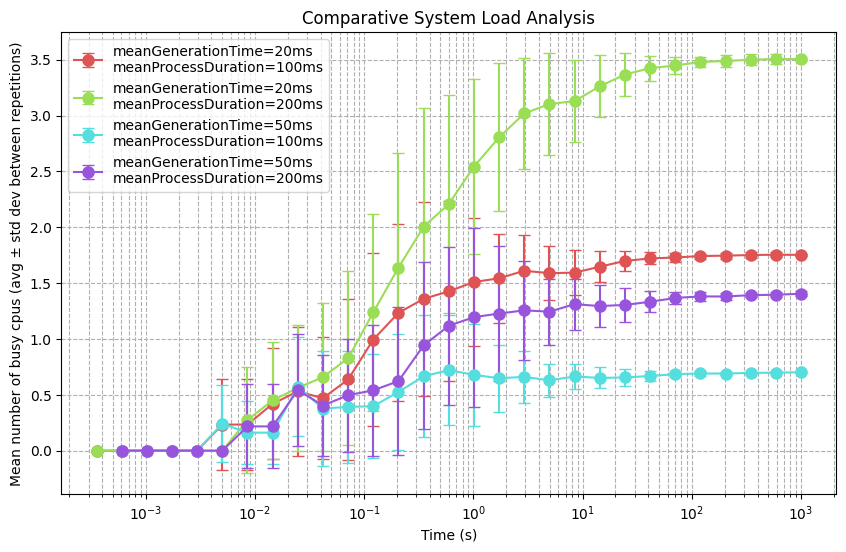

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize data storage structure
measurement_series = {}

# Collect all time points across all measurements for global range
all_times = []

# Process raw data and collect all time points
for key in d_vectors:
    entry = d_vectors[key]
    measurement = entry["measurement"]
    time_data = entry["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]
    
    if measurement not in measurement_series:
        measurement_series[measurement] = []
    
    # Store series and collect time points
    times = np.array(time_data["times"])
    values = np.array(time_data["values"])
    measurement_series[measurement].append((times, values))
    all_times.extend(times)

# Determine global time range
global_min = np.min(all_times)
global_max = np.max(all_times)

# Generate common logarithmic time points
common_times = np.logspace(np.log10(global_min), np.log10(global_max), num=30)
common_times.sort()

# Dictionary to store aligned statistics for each measurement
statistics = {}

# Process each measurement against common time grid
for measurement, series_list in measurement_series.items():
    aligned_values = []
    
    # Align each repetition to common time grid
    for times, values in series_list:
        # Create pandas Series for alignment
        s = pd.Series(values, index=times).sort_index()
        # Forward-fill missing values at common time points
        aligned = s.reindex(common_times, method='ffill')
        aligned_values.append(aligned)
    
    # Combine aligned repetitions
    df = pd.concat(aligned_values, axis=1)
    
    # Calculate statistics
    statistics[measurement] = {
        'avg': df.mean(axis=1),
        'std': df.std(axis=1)
    }

# Create MultiIndex DataFrame
columns = []
data = []

# Preserve original measurement order
for measurement in measurement_series.keys():
    col_label = measurementLabel(measurement)
    data.extend([statistics[measurement]['avg'], statistics[measurement]['std']])
    columns.extend([(col_label, 'Average'), (col_label, 'Std Dev')])

# Create final DataFrame with hierarchical columns
final_df = pd.DataFrame(
    dict(zip(columns, data)),
    index=pd.Index(common_times, name='Time')
)

# Format and print results
pd.set_option('display.float_format', '{:.3f}'.format)
print(final_df.to_string())

# Visualization remains similar but ensure common x-axis
plt.figure(figsize=(12, 7))
for measurement in measurement_series:
    color = colors[measurements.index(measurement)][numVariations//2]
    plt.errorbar(
        common_times,
        statistics[measurement]['avg'],
        yerr=statistics[measurement]['std'],
        fmt='o-',
        label=measurementLabel(measurement),
        markersize=8,
        linewidth=1.5,
        capsize=4,
        capthick=1,
        color=color,
    )

plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Mean number of busy cpus (avg ± std dev between repetitions)')
plt.title('Comparative System Load Analysis')
plt.legend(loc='upper left', framealpha=0.8)
plt.gcf().set_size_inches(10, 6)
plt.grid(True, which='both', linestyle='--')
# plt.tight_layout()
plt.show()

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initialize data storage structure
measurement_series = {}

# Collect all time points across all measurements for global range
all_times = []

# Process raw data and collect all time points
for key in d_vectors:
    entry = d_vectors[key]
    measurement = entry["measurement"]
    time_data = entry["Computer.scheduler"]["numBusyCpus:vector(timeavg)"]
    
    if measurement not in measurement_series:
        measurement_series[measurement] = []
    
    # Store series and collect time points
    times = np.array(time_data["times"])
    values = np.array(time_data["values"])
    measurement_series[measurement].append((times, values))
    all_times.extend(times)

# Determine global time range
global_min = np.min(all_times)
global_max = np.max(all_times)

# Generate common logarithmic time points
common_times = [1,2,5,10,20,50,100,200,500,1000]

# Dictionary to store aligned statistics for each measurement
statistics = {}

# Process each measurement against common time grid
for measurement, series_list in measurement_series.items():
    aligned_values = []
    
    # Align each repetition to common time grid
    for times, values in series_list:
        # Create pandas Series for alignment
        s = pd.Series(values, index=times).sort_index()
        # Forward-fill missing values at common time points
        aligned = s.reindex(common_times, method='ffill')
        aligned_values.append(aligned)
    
    # Combine aligned repetitions
    df = pd.concat(aligned_values, axis=1)
    
    # Calculate statistics
    statistics[measurement] = {
        'avg': df.mean(axis=1),
        'std': df.std(axis=1)
    }

# Create MultiIndex DataFrame
columns = []
data = []

# Preserve original measurement order
for measurement in measurement_series.keys():
    col_label = measurementLabel(measurement)
    data.extend([statistics[measurement]['avg'], statistics[measurement]['std']])
    columns.extend([(col_label, 'Average'), (col_label, 'Std Dev')])

# Create final DataFrame with hierarchical columns
final_df = pd.DataFrame(
    dict(zip(columns, data)),
    index=pd.Index(common_times, name='Time')
)

# Format and print results
pd.set_option('display.float_format', '{:.2f}'.format)
print(final_df.to_string())


     meanGenerationTime=20ms\nmeanProcessDuration=100ms         meanGenerationTime=20ms\nmeanProcessDuration=200ms         meanGenerationTime=50ms\nmeanProcessDuration=100ms         meanGenerationTime=50ms\nmeanProcessDuration=200ms        
                                                Average Std Dev                                            Average Std Dev                                            Average Std Dev                                            Average Std Dev
Time                                                                                                                                                                                                                                            
1                                                  1.52    0.58                                               2.54    0.78                                               0.68    0.46                                               1.20    0.80
2                                   

In [110]:
latex_table = final_df.to_latex(
    float_format="%.2f",  # Format floats to 2 decimal places
    caption="Performance metrics for different configurations of meanGenerationTime and meanProcessDuration.",  # Add a caption
    label="tab:performance",  # Add a label for referencing
    column_format="c" + "c" * len(final_df.columns),  # Center-align all columns
    multicolumn_format="c",  # Center-align multi-level headers
    multirow=True  # Enable multirow for hierarchical columns
)

# Save the LaTeX table to a file
with open("output_table.tex", "w") as f:
    f.write(latex_table)

print("LaTeX table saved to 'output_table.tex'.")

LaTeX table saved to 'output_table.tex'.
